/global/homes/r/rroussel/.conda/envs/phase_space_reconstruction/lib/python3.10/site-packages/tqdm/auto.py:22: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm
/global/homes/r/rroussel/.conda/envs/phase_space_reconstruction/lib/python3.10/site-packages/torch/functional.py:568: UserWarning: torch.meshgrid: in an upcoming release, it will be required to pass the indexing argument. (Triggered internally at  /opt/conda/conda-bld/pytorch_1646755897462/work/aten/src/ATen/native/TensorShape.cpp:2228.)
  return _VF.meshgrid(tensors, **kwargs)  # type: ignore[attr-defined]


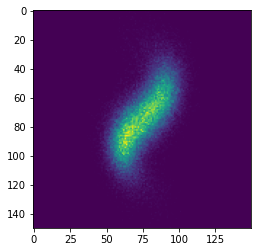

In [1]:
import torch
from copy import deepcopy
from torch.utils.data import DataLoader, Dataset, random_split
from torchensemble import VotingRegressor, SnapshotEnsembleRegressor
import matplotlib.pyplot as plt

import sys
sys.path.append("../../")

from modeling import Imager, InitialBeam, QuadScanTransport, \
    NonparametricTransform
from fitting import MaxEntropyQuadScan, ImageDataset

folder = "../../test_case_4/"
all_k = torch.load(folder + "kappa.pt")
all_images = torch.load(folder + "images.pt").unsqueeze(1)
bins = torch.load(folder + "bins.pt")
gt_initial_beam = torch.load(folder + "ground_truth_dist.pt")


#bins = (bins[:-1] + bins[1:])/2
xx = torch.meshgrid(bins, bins)

all_k = all_k.cpu()[::2]
all_images = all_images.cpu()[::2]

for ele in all_images[::10]:
    plt.figure()
    plt.imshow(ele[0])

train_dset = torch.load("train.dset")
test_dset = torch.load("test.dset")

train_dataloader = DataLoader(train_dset, batch_size=2)
test_dataloader = DataLoader(test_dset)


bandwidth = torch.tensor(1.0e-4)

defaults = {
    "s": torch.tensor(0.0).float(),
    "p0c": torch.tensor(10.0e6).float(),
    "mc2": torch.tensor(0.511e6).float(),
}

transformer = NonparametricTransform(2, 50, 0.0, torch.nn.Tanh())
#transformer.eval()

base_dist = torch.distributions.Uniform(-torch.ones(6), torch.ones(6))

module_kwargs = {
        "initial_beam": InitialBeam(100000, transformer, base_dist, **defaults),
        "transport": QuadScanTransport(torch.tensor(0.1), torch.tensor(1.0)),
        "imager": Imager(bins, bandwidth),
        "condition": False
    }

ensemble = VotingRegressor(
    estimator=MaxEntropyQuadScan,
    estimator_args=module_kwargs,
    n_estimators=5,
)

#ensemble = VotingRegressor(
#    estimator=QuadScanModel,
#    estimator_args=module_kwargs,
#    n_estimators=1,
#    n_jobs=1
#)

class CustomLoss(torch.nn.MSELoss):
    pass


criterion = CustomLoss()
ensemble.set_criterion(criterion)

ensemble.set_optimizer(
    "Adam",
    lr=0.01
)

from torchensemble.utils import io
io.load(ensemble, ".")
ensemble = ensemble
ensemble.cpu();

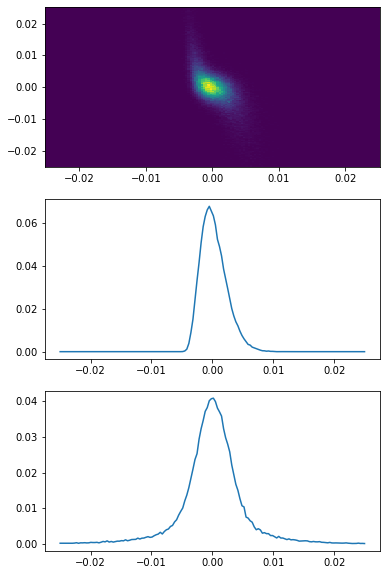

In [2]:
def calc_rms_size(xxx, images):
    # note image sums are normalized to 1

    fig,ax = plt.subplots(3,1)
    fig.set_size_inches(6,10)
    ax[0].pcolor(*xxx, images[-1,0])

    xx_ = xxx[0].unsqueeze(0).unsqueeze(0).repeat(*images.shape[:2], 1, 1)
    yy_ = xxx[1].unsqueeze(0).unsqueeze(0).repeat(*images.shape[:2], 1, 1)
    proj_x = images.sum(dim=-1)
    proj_y = images.sum(dim=-2)

    x = xx_[...,:,0]
    y = yy_[...,0,:]

    ax[1].plot(x[-1,0], proj_x[-1,0])
    ax[2].plot(y[-1,0], proj_y[-1,0])


    mean_x = torch.sum(x * proj_x, dim=-1).unsqueeze(-1)
    mean_y = torch.sum(y * proj_y, dim=-1).unsqueeze(-1)

    var_x = torch.sum((x - mean_x)**2 * proj_x, dim=-1).unsqueeze(-1)
    var_y = torch.sum((y - mean_y)**2 * proj_y, dim=-1).unsqueeze(-1)

    # calculate cross covariance
    #var_xy = torch.sum((xx_ - mean_x)*(yy_ - mean_y)*images, dim=-1).unsqueeze(-1)

    return torch.cat([mean_x, mean_y], dim=-1), torch.cat([var_x, var_y], dim=-1)

means, variances = calc_rms_size(xx, all_images)


In [3]:


train_k = all_k[train_dset.indices]
train_k = train_k.cpu()

train_im = all_images[train_dset.indices]
train_im = train_im.cpu()

test_k = all_k[test_dset.indices]
test_k = test_k.cpu()

test_im = all_images[test_dset.indices]
test_im = test_im.cpu()
print(all_images.shape)

torch.Size([10, 1, 150, 150])


In [4]:
recompute_images = True
with torch.no_grad():
    if recompute_images:
        dist = torch.distributions.MultivariateNormal(torch.zeros(6), torch.eye(6))
        custom_beam = None#dist.sample([100000]).cuda()

        model_pred = torch.cat(
            [ensemble[i](all_k[:,:1])[0].unsqueeze(0) for i in range(len(ensemble))]
        )
        model_pred = torch.transpose(model_pred.squeeze(dim=2), 0,1)
        model_pred = model_pred.cpu().detach()

        torch.save(model_pred, "all_pred_images.pt")
    else:
        model_pred = torch.load("all_pred_images.pt")


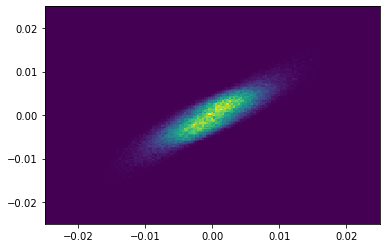

In [6]:
from visualization import add_image
fig,ax = plt.subplots()
add_image(ax,"x","y", [ensemble[0].beam_generator()],[bins]*2);

tensor([2.6841e-04, 3.2746e-05]) tensor([0.0021, 0.0051])
tensor([ 2.7397e-04, -2.0188e-06]) tensor([0.0021, 0.0051])
torch.Size([10, 5, 150, 150])
torch.Size([10, 1, 150, 150])


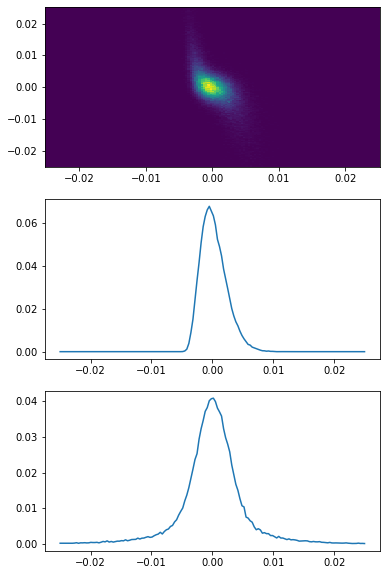

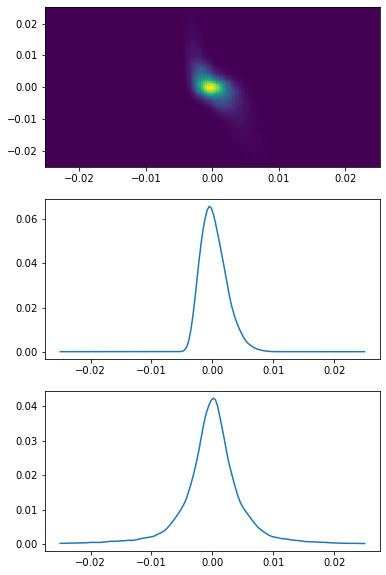

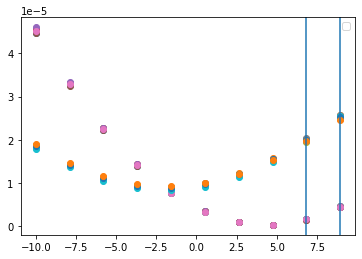

In [7]:
means, variances = calc_rms_size(xx, all_images)
pmeans, pvariances = calc_rms_size(xx, model_pred)

print(means[-1,0], variances[-1,0].sqrt())
print(pmeans[-1,0], pvariances[-1,0].sqrt())


fig,ax = plt.subplots()
k = all_k[:, 0]
#mean_variance = torch.mean(variances, dim=-2)
#error_variance = torch.std(variances, dim=-2)

ax.plot(k, variances[...,0],'o')
ax.plot(k, variances[...,1],'o')

#ax.errorbar(k, mean_variance[...,0], error_variance[...,0],capsize=5,ls='',
# label="true_x")
#ax.errorbar(k, mean_variance[...,1], error_variance[...,1],capsize=5,ls='',
# label="true_y")

print(model_pred.shape)
print(all_images.shape)

mean_pvariance = torch.mean(pvariances, dim=-2)
error_pvariance = torch.std(pvariances, dim=-2)

ax.plot(k, pvariances[...,0],'o')
ax.plot(k, pvariances[...,1],'o')

#ax.errorbar(k, mean_pvariance[...,0], error_pvariance[...,0],capsize=5,ls='', label="pred_x")
#ax.errorbar(k, mean_pvariance[...,1], error_pvariance[...,1],capsize=5,ls='',
# label="pred_y")

for ele in test_dset.indices:
    ax.axvline(all_k[ele,0])

ax.legend()

torch.Size([10, 1, 150, 150])


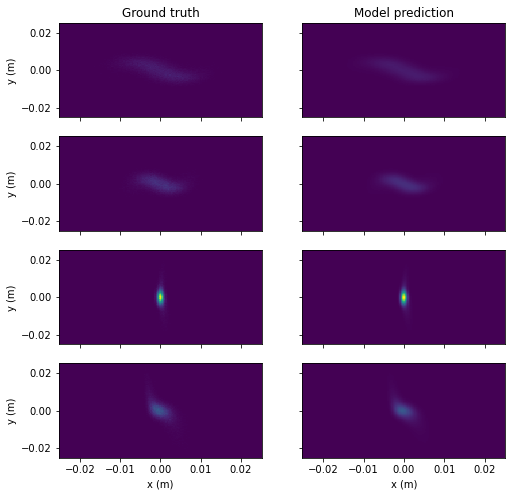

In [8]:
from visualization import compare_images
print(all_images.shape)
image_slice = [1,3,-3,-1]
fig = compare_images(xx, model_pred.mean(dim=1)[image_slice], all_images.mean(dim=1)[image_slice])
#fig = compare_images(xx, model_pred[:6,0], all_images[:6,0])
fig.set_size_inches(8,8)

torch.Size([10, 1, 150, 150])
torch.Size([10, 5, 150, 150])


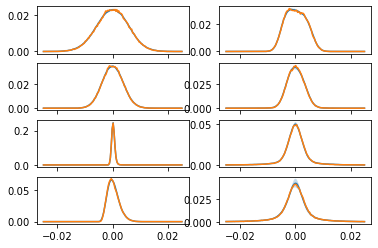

In [9]:
from visualization import compare_image_projections
print(all_images.shape)
print(model_pred.shape)

fig = compare_image_projections(xx[0].T[0], model_pred[image_slice], all_images[image_slice])


In [10]:
# compare initial beam distributions
from torch_track import Beam
defaults = {
    "s": torch.tensor(0.0).float(),
    "p0c": torch.tensor(10.0e6).float(),
    "mc2": torch.tensor(0.511e6).float(),
}

gt_initial_beam = Beam(gt_initial_beam, **defaults)

# generate beams from model
pred_initial_beams = [ele.beam_generator() for ele in ensemble]


0.013630106439052608
0.012834733421645378
0.017432842763779037
tensor(0.0811, grad_fn=<StdBackward0>)
tensor(0.0424, grad_fn=<StdBackward0>)


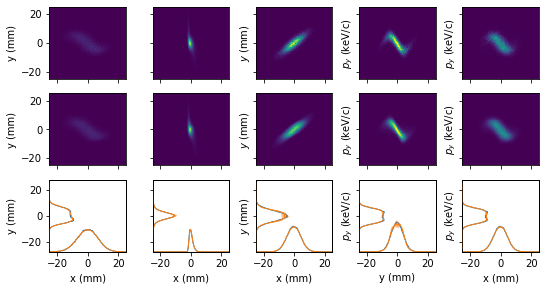

In [11]:
from visualization import add_image, add_projection, add_image_projection
import numpy as np
import matplotlib.gridspec as gridspec
from matplotlib.axes import SubplotBase
pairs = [["x","y"],["y","py"],["x","py"]]

fig,ax = plt.subplots(3,len(pairs)+2, sharex="col",sharey="row")
fig.subplots_adjust(wspace=0.35, right=0.975, top=0.975)
fig.set_size_inches(8,4)
    
plot_bins = bins
#plot_bins = plot_bins * 1e3

vmax = 0.2e5
linewidth=1.0
for g, pair in enumerate(pairs):
    i = g + 2
    
    plot_bins = [bins]*2
    scale = 1e3
    if pair == ["z","pz"]:
        plot_bins = bins*10
        scale = 1e6
    
    _, gt_image = add_image(ax[0][i], *pair, [gt_initial_beam], plot_bins,
                            scale_axis=scale,vmax=vmax)
    #print(np.max(gt_image))
    _, pred_image = add_image(ax[1][i], *pair, pred_initial_beams, plot_bins,
                           scale_axis=scale,vmax=vmax)

    # calculate rms error
    rms_error = np.sqrt(((gt_image - pred_image)**2).sum() / gt_image.size)
    print(rms_error / np.max(gt_image))

    if pair[-1]=="y":
        for a in ax[:,i]:
            a.set_ylabel("$y$ (mm)")
    elif pair[-1]=="py":
        for a in ax[:,i]:
            a.set_ylabel("$p_y$ (keV/c)")
    elif pair[-1]=="px":
        for a in ax[:,i]:
            a.set_ylabel("$p_x$ (keV/c)")

    # x projections
    max_dens = 250
    axa = ax[2][i].twinx()
    add_projection(axa, pair[0], [gt_initial_beam], plot_bins[0], x_scale=scale, y_scale=1)
    add_projection(axa, pair[0], pred_initial_beams, plot_bins[0], x_scale=scale, y_scale=1)
    axa.set_ylim(0,max_dens)
    axa.set_yticks([])
    
    # y projections
    axb = ax[2][i].twiny()
    add_projection(axb, pair[1], [gt_initial_beam], plot_bins[1],axis="y",x_scale=scale, y_scale=1)
    add_projection(axb, pair[1], pred_initial_beams, plot_bins[1],axis="y", x_scale=scale, y_scale=1)
    axb.set_xlim(0,max_dens)
    axb.set_xticks([])
    
    for ele in [axa,axb]:
        for line in ele.get_lines():
            line.set(linewidth=linewidth)    
        ele.get_lines()[0].set(zorder=0)

    ax[2][i].set_xlabel(pair[0] + " (mm)")

idxs = [train_dset.indices[0],test_dset.indices[0]]
plot_bins = bins

im_vmax = all_images[idxs[-1],0].max()
for j, idx in enumerate(idxs):

    ax[0][j].pcolor(xx[0]*1e3,xx[1]*1e3, all_images[idx,0],vmax=im_vmax*1.1)
    ax[1][j].pcolor(xx[0]*1e3,xx[1]*1e3, model_pred[idx,0],vmax=im_vmax*1.1)

    ax[0][j].collections[0].set_rasterized(True)

    colors = ["C0","C1"]
    axa = ax[2][j].twinx()
    axb = ax[2][j].twiny()
    
    for h, ele in enumerate([all_images, model_pred]):
        axa = add_image_projection(axa, ele[idx], plot_bins, "x", scale_x=1e3,c=colors[h])
        axb = add_image_projection(axb, ele[idx], plot_bins, "y", scale_x=1e3, c=colors[h])
        
        
       
    for ele in [axa,axb]:
        for line in ele.get_lines():
            line.set(linewidth=linewidth)    
        ele.get_lines()[0].set(zorder=0)
        
    axa.set_ylim(0, axa.get_ylim()[-1]*3.0)
    axb.set_xlim(0, axb.get_xlim()[-1]*3.0)
    axa.set_yticks([])
    axb.set_xticks([])


    ax[0][j].set_xlim(-25,25)
    ax[0][j].set_ylim(-25,25)
    ax[1][j].set_ylim(-25,25)

# set rasterization for pcolor
for k in range(ax.shape[-1]):
    ax[0,k].collections[0].set_rasterized(True)
    ax[1,k].collections[0].set_rasterized(True)


ax[-1,0].set_xlabel('x (mm)')
ax[-1,1].set_xlabel('x (mm)')
ax[-1,0].set_ylabel('y (mm)')


ax[0,0].set_ylabel('y (mm)')
ax[1,0].set_ylabel('y (mm)')

print(pred_initial_beams[0].z.std())
print(pred_initial_beams[0].pz.std())

# set ticks for lower x-axis
for a in ax[-1]:
    a.set_xticks([-20,0,20])
    
#fig.tight_layout()

fig.savefig("testfig.svg")

tensor(0.0811, grad_fn=<StdBackward0>)
tensor(0.0424, grad_fn=<StdBackward0>)


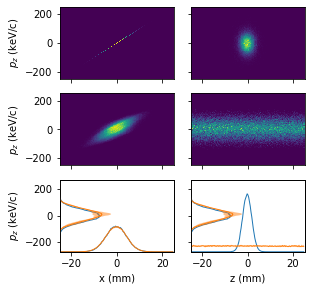

In [25]:
from visualization import add_image, add_projection, add_image_projection
import numpy as np
import matplotlib.gridspec as gridspec
from matplotlib.axes import SubplotBase
pairs = [["x","pz"],["z","pz"]]

fig,ax = plt.subplots(3,len(pairs), sharex="col",sharey="row")
fig.subplots_adjust(wspace=0.15, right=0.975, top=0.975)
fig.set_size_inches(4,4)
    
bins_dict = {"x":bins, "z": bins, "pz":bins*10}
#plot_bins = plot_bins * 1e3

linewidth=1.0
for i, pair in enumerate(pairs):    
    plot_bins = bins
    scale = 1e3
    
    plot_bins = [bins_dict[e] for e in pair]
    
    _, gt_image = add_image(ax[0][i], *pair, [gt_initial_beam], plot_bins,
                            scale_axis=scale)
    #print(np.max(gt_image))
    _, pred_image = add_image(ax[1][i], *pair, pred_initial_beams, plot_bins,
                           scale_axis=scale)


    # x projections
    max_dens = 250
    axa = ax[2][i].twinx()
    add_projection(axa, pair[0], [gt_initial_beam], plot_bins[0], x_scale=scale, y_scale=1)
    add_projection(axa, pair[0], pred_initial_beams, plot_bins[0], x_scale=scale, y_scale=1)
    axa.set_ylim(0,max_dens)
    axa.set_yticks([])
    
    # y projections
    axb = ax[2][i].twiny()
    add_projection(axb, pair[1], [gt_initial_beam], plot_bins[1],axis="y",x_scale=scale, y_scale=1)
    add_projection(axb, pair[1], pred_initial_beams, plot_bins[1],axis="y", x_scale=scale, y_scale=1)
    axb.set_xlim(0,max_dens/10)
    axb.set_xticks([])
    
    for ele in [axa,axb]:
        for line in ele.get_lines():
            line.set(linewidth=linewidth)    
        ele.get_lines()[0].set(zorder=0)

    ax[2][i].set_xlabel(pair[0] + " (mm)")

idxs = [train_dset.indices[0],test_dset.indices[0]]
plot_bins = bins

# set rasterization for pcolor
for k in range(ax.shape[-1]):
    ax[0,k].collections[0].set_rasterized(True)
    ax[1,k].collections[0].set_rasterized(True)

ax[-1,0].set_xlabel('x (mm)')
ax[-1,1].set_xlabel('z (mm)')
for a in ax[:,0]:
    a.set_ylabel("$p_z$ (keV/c)")

print(pred_initial_beams[0].z.std())
print(pred_initial_beams[0].pz.std())

# set ticks for lower x-axis
for a in ax[-1]:
    a.set_xticks([-20,0,20])
    
fig.savefig("longitudinal_dist.svg")

In [ ]:
# calculate the covariances
#torch.cov(gt_initial_beam.data.T)[:2,:2].det().sqrt()
torch.cov(gt_initial_beam.data.T)[2:4,2:4].det().sqrt()

In [ ]:
#torch.cov(pred_initial_beams[0].data.T)[:2,:2].det().sqrt()
torch.cov(pred_initial_beams[0].data.T)[2:4,2:4].det().sqrt()

In [ ]:
# compute particle coordinates in normalized space
from pmd_beamphysics.statistics import A_mat_calc

def get_beam_norm_amp_dist(beam, key="y"):
    gt_cov = torch.cov(beam.data.T).detach()
    idx = 2 if key == "y" else 0
    gt_cov_x = gt_cov[idx:idx+2, idx:idx+2]
    emit = torch.det(gt_cov_x).sqrt()
    beta = gt_cov_x[0,0] / emit
    alpha = - gt_cov_x[0,1] / emit

    A_inv = A_mat_calc(beta.numpy(), alpha.numpy(), inverse=True)
    a = getattr(beam, key).detach().numpy()
    pa = getattr(beam, key + "p").detach().numpy()
    norm_a = A_inv[0,0] * a
    norm_pa = A_inv[1,0] * a + A_inv[1,1] * pa

    J = (norm_a**2 + norm_pa**2) / 2
    return J

def get_beam_sorted_by_J(beam, key="y"):
    J = torch.tensor(get_beam_norm_amp_dist(beam, key))
    return beam.data[torch.argsort(J)]

def get_quantile(beam, q, key="y"):
    J = torch.tensor(get_beam_norm_amp_dist(beam, key))
    n_particles = beam.data.shape[0]
    return beam.data[torch.argsort(J)][:int(n_particles*q)], J[torch.argsort(J)][: int(n_particles*q)]

def get_emittance_vs_quantile(beam, qs, key="y"):
    emits = []
    idx = 2 if key == "y" else 0
    sorted_beam = get_beam_sorted_by_J(beam).detach()
    n_particles = beam.data.shape[0]
    for q in qs:
        emits.append(
            torch.cov(
                sorted_beam[:int(n_particles*q)].T)[idx:idx+2,idx:idx+2].det().sqrt()
        )
    return torch.tensor(emits)

jbins = np.linspace(0, 1.5e-4,100)
J_gt = get_beam_norm_amp_dist(gt_initial_beam)
J_pred = get_beam_norm_amp_dist(pred_initial_beams[0])

quantiles = torch.linspace(0.01,1,50)

fig,ax = plt.subplots()

for axis in ["x","y"]:
    gt_emits = get_emittance_vs_quantile(gt_initial_beam, quantiles,axis)*1e6

    temp = []
    for ele in pred_initial_beams:
        temp.append(get_emittance_vs_quantile(ele, quantiles,axis).unsqueeze(0))

    temp = torch.cat(temp, dim=0)*1e6
    mean = torch.mean(temp, dim=0)
    l = torch.quantile(temp, 0.05, dim=0)
    u = torch.quantile(temp, 0.95, dim=0)

    ax.plot(quantiles, gt_emits)
    ax.plot(quantiles, mean)
    ax.fill_between(quantiles, l, u, alpha=0.5)

In [ ]:
proj = model_pred[1].sum(dim=-1)
proj = proj / proj.max()

mean_proj = torch.mean(proj, dim=0)
l = torch.quantile(proj, 0.05, dim=0)
u = torch.quantile(proj, 0.95, dim=0)

In [ ]:
plt.plot(u.detach())

In [ ]:
# set up major GridSpec
import matplotlib.gridspec as gridspec
from matplotlib.axes import SubplotBase

fig = plt.figure()
n_images = 2
n_phase_spaces = 4


gs0 = gridspec.GridSpec(3, n_images+n_phase_spaces, figure=fig, wspace=0.25, right=0.95, left=0.05)

# axes for plotting images
gs00 = gs0[:n_images].subgridspec(3,n_images)
images_ax = np.empty((3,n_images), dtype=SubplotBase)
for ii in range(3):
    for jj in range(n_images):
        images_ax[ii,jj] = fig.add_subplot(gs00[ii,jj]) 
        
gs01 = gs0[n_images:].subgridspec(3,n_phase_spaces)
phase_space_ax = np.empty((3,n_phase_spaces), dtype=SubplotBase)
for ii in range(3):
    for jj in range(n_phase_spaces):
        images_ax[ii,jj] = fig.add_subplot(gs01[ii,jj]) 